In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, r2_score

import datetime
%matplotlib inline

In [2]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

In [4]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 1
#kernel_size3 = 5
n_grid = 128
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "alpha"+ str(int(alpha[j])) + "_velocityMagnitudeInterpolated.csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, n_grid+1, n_grid+1))

In [14]:
image = 1-image/100

In [15]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [16]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [17]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cl_nor = (cl-np.min(cl))/(np.max(cl)-np.min(cl))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
cd_nor = (cd-np.min(cd))/(np.max(cd)-np.min(cd))

y = np.hstack((cl, cd))
y_nor = np.hstack((cl_nor, cd_nor))

In [18]:
y_nor = y_nor.reshape((133, 16, 2, 1))

In [19]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [21]:
geometry.shape

(2128, 1)

In [22]:
geometry = geometry.reshape((133, 16, 1))

In [23]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y_nor, test_size=0.05, random_state=1)

In [24]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [25]:
x_train.shape

(2016, 129, 129, 1)

In [26]:
#with mirrored_strategy.scope():
input_image = tf.keras.Input(shape=(n_grid+1, n_grid+1, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(1, (kernel_size2, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)

reshape1 = tf.keras.layers.Flatten()(x_conv)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [27]:
#with mirrored_strategy.scope():
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 129, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 129, 129, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 64, 64, 1)         101       
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               819400    
                                                             

In [28]:
#with mirrored_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [29]:
es = EarlyStopping(monitor='loss', mode='min', patience=200,
                   restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'loss',factor = 0.5, patience = 25,
                              min_lr = 1e-8, mode = 'min', verbose = 1)

model_name = "D:\\TrainedModels\\20221024\\" + "AeroCNN-II_ClCd_nGrid128_100kernel_2by2MaxPooling_1CNNlayer_testSize0.05(normalized).h5"
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True,
                                monitor = 'loss', mode='min')

In [30]:
#with mirrored_strategy.scope():
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True,
                    callbacks=[es, reduce_lr, checkpoint_cb])
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 3s 10ms/step - loss: 0.1723 - rmse: 0.4151 - lr: 0.0010
Epoch 2/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.1411 - rmse: 0.3757 - lr: 0.0010
Epoch 3/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.1176 - rmse: 0.3429 - lr: 0.0010
Epoch 4/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0994 - rmse: 0.3153 - lr: 0.0010
Epoch 5/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0853 - rmse: 0.2920 - lr: 0.0010
Epoch 6/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0744 - rmse: 0.2728 - lr: 0.0010
Epoch 7/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0663 - rmse: 0.2574 - lr: 0.0010
Epoch 8/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0603 - rmse: 0.2456 - lr: 0.0010
Epoch 9/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0560 - rmse: 0.2366 - lr: 0.0010
Epoch 10/5

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 72/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 73/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 74/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 75/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 76/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 77/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 78/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.5000e-04
Epoch 79/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - l

Epoch 140/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 6.2500e-05
Epoch 141/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 6.2500e-05
Epoch 142/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 6.2500e-05
Epoch 143/5000
61/63 [============================>.] - ETA: 0s - loss: 0.0480 - rmse: 0.2190
Epoch 143: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 6.2500e-05
Epoch 144/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.1250e-05
Epoch 145/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.1250e-05
Epoch 146/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.1250e-05
Epoch 147/5000
63/63 [===============

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 208/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 209/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 210/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 211/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 212/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 213/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 214/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 7.8125e-06
Epoch 215/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.21

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 275/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 276/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 277/5000
63/63 [==============================] - 1s 10ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 278/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 279/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 280/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 281/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 9.7656e-07
Epoch 282/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.4414e-07
Epoch 343/5000
61/63 [============================>.] - ETA: 0s - loss: 0.0478 - rmse: 0.2187
Epoch 343: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 2.4414e-07
Epoch 344/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.2207e-07
Epoch 345/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.2207e-07
Epoch 346/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.2207e-07
Epoch 347/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.2207e-07
Epoch 348/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.2207e-07
Epoch 349/5000
63/63 [==============================

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 410/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 411/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 412/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 413/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 414/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 415/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 416/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 3.0518e-08
Epoch 417/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.21

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 478/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 479/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 480/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 481/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 482/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 483/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 484/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 485/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.21

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 549/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 550/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 551/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 552/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 553/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 554/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 555/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 556/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.21

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 620/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 621/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 622/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 623/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 624/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 625/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 626/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 627/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.21

63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 691/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 692/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 693/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 694/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 695/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 696/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 697/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.2181 - lr: 1.0000e-08
Epoch 698/5000
63/63 [==============================] - 1s 9ms/step - loss: 0.0476 - rmse: 0.21

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:06:51.748622


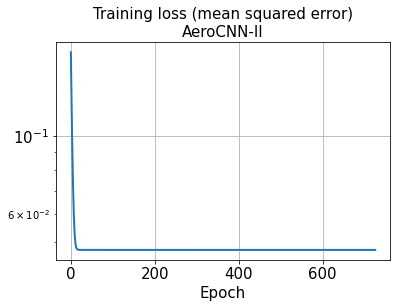

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

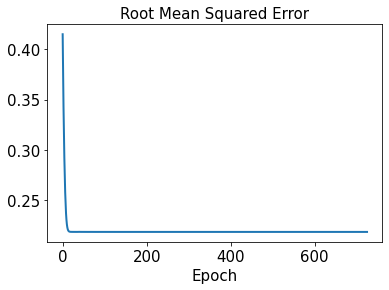

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

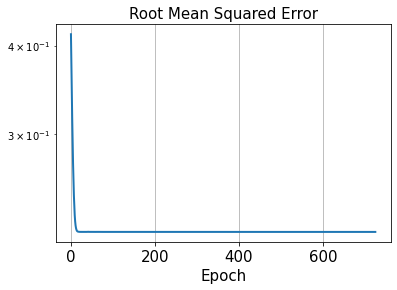

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [52]:
#with mirrored_strategy.scope():
test_results = model.evaluate(x_train, y_train)

63/63 [==============================] - 1s 8ms/step - loss: 0.0476 - rmse: 0.2181


In [53]:
test_results = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.0467 - rmse: 0.2162


In [54]:
#with mirrored_strategy.scope():
decoded_train = model.predict(x_train)

63/63 [==============================] - 1s 8ms/step


In [55]:
decoded_train.shape

(2016, 2, 1)

In [57]:
#with mirrored_strategy.scope():
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 56ms/step


In [58]:
decoded_test.shape

(112, 2, 1)

In [69]:
cl_train_refrained = decoded_train[:,0,:]*(np.max(cl)+np.min(cl)) + np.min(cl)
cl_test_refrained = decoded_test[:,0,:]*(np.max(cl)+np.min(cl)) + np.min(cl)
cd_train_refrained = decoded_train[:,1,:]*(np.max(cl)+np.min(cl)) + np.min(cl)
cd_test_refrained = decoded_test[:,1,:]*(np.max(cl)+np.min(cl)) + np.min(cl)

In [70]:
cl_train_refrained.shape

(2016, 1)

In [71]:
cd_train_refrained.shape

(2016, 1)

In [72]:
cd_test_refrained.shape

(112, 1)

In [73]:
x_train.shape[0]

2016

In [74]:
decoded_train = np.concatenate((cl_train_refrained.reshape((int(x_train.shape[0]/2),2,1)),
                                cd_train_refrained.reshape((int(x_train.shape[0]/2),2,1))), axis=0)
decoded_test = np.concatenate((cl_test_refrained.reshape((int(x_test.shape[0]/2),2,1)),
                               cd_test_refrained.reshape((int(x_test.shape[0]/2),2,1))), axis=0)

In [75]:
error_train_abs = np.abs(decoded_train - y_train)

In [76]:
error_test_abs = np.abs(decoded_test - y_test)

In [77]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [78]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [79]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [80]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [81]:
os.chdir("D:\\TrainedModels\\20221024")
model.save('AeroCNN-II_ClCd_nGrid128_100kernel_2by2MaxPooling_1CNNlayer_testSize0.05(normalized)(1x1convAdded).h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [82]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

4.341457293811594


In [83]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

4.327337592329249


In [84]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

3.6623517216522457


In [85]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

6.986024339376438


In [ ]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

In [ ]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

In [ ]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

In [ ]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

In [ ]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

In [ ]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

In [ ]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

In [ ]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

In [ ]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

In [ ]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 100 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()